## Env Creative

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio.v2

## Function to add Gaussian noise to the image

In [2]:
def add_noise(img, noise_level):
    noise = np.random.normal(0, noise_level, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 1)

## Define the DIP model

In [3]:
class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

## Load target image

In [4]:
img_path = '/kaggle/input/lenna-test-image/Lenna_(test_image).png'
target_img = imageio.v2.imread(img_path)

if target_img.dtype == np.uint8:
    target_img = target_img / 255.0

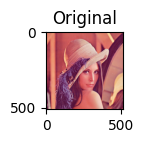

In [5]:
plt.figure(figsize=(3, 1))
plt.title("Original")
plt.imshow(np.clip(target_img, 0, 1))
plt.show()

## Define noise levels and schedule

In [6]:
schedules = {
    "gradual": [0.1, 0.05, 0.025],
    "fast": [0.1, 0.01, 0.001],
    "slow": [0.1, 0.09, 0.08]
}

## Prepare for Training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
def initialize_model():
    model = DIPModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    return model, optimizer

In [9]:
def train_schedule(schedule_name, noise_levels):
    psnr_results = []
    ssim_results = []

    noisy_images = [add_noise(target_img, noise_level) for noise_level in noise_levels]
    noisy_images_torch = [torch.tensor(img.transpose(2, 0, 1)).unsqueeze(0).float() for img in noisy_images]
    noisy_images_torch = [img.to(device) for img in noisy_images_torch]
    target_img_torch = torch.tensor(target_img.transpose(2, 0, 1)).unsqueeze(0).float().to(device)

    model, optimizer = initialize_model()
    criterion = nn.MSELoss()

    num_epochs_per_stage = 200
    patience = 50
    best_psnr = 0
    best_model = None
    eval_interval = 10

    for stage, noisy_img_torch in enumerate(noisy_images_torch):
        print(f"Training on schedule {schedule_name}, stage {stage + 1} with noise level {noise_levels[stage]}")
        no_improvement_count = 0

        for epoch in tqdm(range(num_epochs_per_stage)):
            model.train()
            optimizer.zero_grad()
            output = model(noisy_img_torch)
            loss = criterion(output, target_img_torch)
            loss.backward()
            optimizer.step()

            if epoch % eval_interval == 0 or epoch == num_epochs_per_stage - 1:
                model.eval()
                with torch.no_grad():
                    output_img = output.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
                    output_img = np.clip(output_img, 0, 1)
                    current_psnr = psnr(target_img, output_img, data_range=1.0)
                    current_ssim = ssim(target_img, output_img, data_range=1.0, channel_axis=-1)

                    if current_psnr - best_psnr >= 0.001:
                        best_psnr = current_psnr
                        best_model = model.state_dict()
                        # no_improvement_count = 0
                    else:
                        no_improvement_count += 1

                    if no_improvement_count >= patience:
                        print(f"Early stopping at epoch {epoch} in schedule {schedule_name}, stage {stage + 1}")
                        break

        model.load_state_dict(best_model)
        psnr_results.append(best_psnr)
        ssim_results.append(current_ssim)

    return psnr_results, ssim_results

## Training

In [10]:
results = {}
for schedule_name, noise_levels in schedules.items():
    psnr_results, ssim_results = train_schedule(schedule_name, noise_levels)
    results[schedule_name] = {
        "psnr": psnr_results,
        "ssim": ssim_results
    }

Training on schedule gradual, stage 1 with noise level 0.1


100%|██████████| 200/200 [00:08<00:00, 23.62it/s]


Training on schedule gradual, stage 2 with noise level 0.05


100%|██████████| 200/200 [00:07<00:00, 26.45it/s]


Training on schedule gradual, stage 3 with noise level 0.025


100%|██████████| 200/200 [00:07<00:00, 26.37it/s]


Training on schedule fast, stage 1 with noise level 0.1


100%|██████████| 200/200 [00:06<00:00, 29.86it/s]


Training on schedule fast, stage 2 with noise level 0.01


100%|██████████| 200/200 [00:06<00:00, 29.75it/s]


Training on schedule fast, stage 3 with noise level 0.001


100%|██████████| 200/200 [00:06<00:00, 29.59it/s]


Training on schedule slow, stage 1 with noise level 0.1


100%|██████████| 200/200 [00:06<00:00, 29.42it/s]


Training on schedule slow, stage 2 with noise level 0.09


100%|██████████| 200/200 [00:06<00:00, 29.42it/s]


Training on schedule slow, stage 3 with noise level 0.08


100%|██████████| 200/200 [00:06<00:00, 29.34it/s]


## Visulize the result

In [11]:
for schedule_name, metrics in results.items():
    psnr_formatted = [f'{val:.4f}' for val in metrics["psnr"]]
    ssim_formatted = [f'{val:.4f}' for val in metrics["ssim"]]
    print(f'PSNR results for {schedule_name}: {psnr_formatted}')
    print(f'SSIM results for {schedule_name}: {ssim_formatted}')

PSNR results for gradual: ['30.2496', '33.2330', '35.8764']
SSIM results for gradual: ['0.7704', '0.8572', '0.9124']
PSNR results for fast: ['30.2694', '37.2139', '38.8598']
SSIM results for fast: ['0.7703', '0.9390', '0.9602']
PSNR results for slow: ['29.1811', '30.3578', '31.1056']
SSIM results for slow: ['0.7414', '0.7751', '0.7969']


Average PSNR for gradual: 33.1197
Average PSNR for fast: 35.4477
Average PSNR for slow: 30.2149


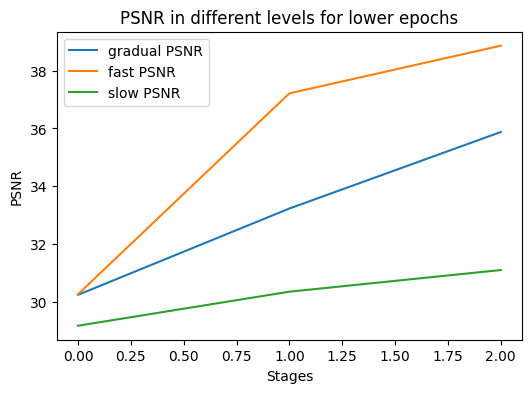

In [12]:
plt.figure(figsize=(6, 4))
for schedule_name, metrics in results.items():
    plt.plot(metrics["psnr"], label=f'{schedule_name} PSNR')
    avg_psnr = np.mean(metrics["psnr"])
    print(f'Average PSNR for {schedule_name}: {avg_psnr:.4f}')
plt.xlabel('Stages')
plt.ylabel('PSNR')
plt.legend()
plt.title('PSNR in different levels for lower epochs')
plt.show()

Average SSIM for gradual: 0.8467
Average SSIM for fast: 0.8898
Average SSIM for slow: 0.7711


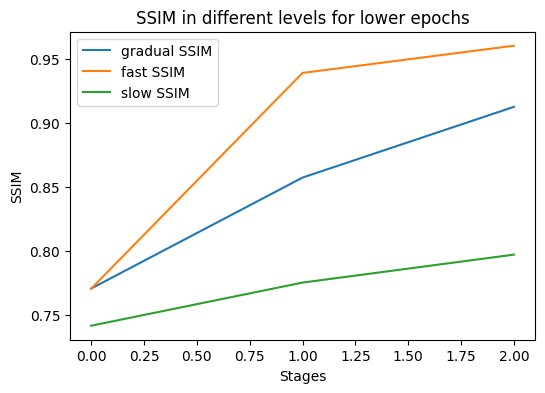

In [13]:
plt.figure(figsize=(6, 4))
for schedule_name, metrics in results.items():
    plt.plot(metrics["ssim"], label=f'{schedule_name} SSIM')
    avg_ssim = np.mean(metrics["ssim"])
    print(f'Average SSIM for {schedule_name}: {avg_ssim:.4f}')
plt.xlabel('Stages')
plt.ylabel('SSIM')
plt.legend()
plt.title('SSIM in different levels for lower epochs')
plt.show()